<a href="https://colab.research.google.com/github/dreamtx01/Springboard/blob/master/Capstone_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Using NCAA Season DATA from 2003 - 2019**

This notebook will use a supervised logistic regression model to predict in game statistics that could be used to influence the outcome of matches

**1.Housekeeping** 
**IMPORT LIBRARIES**

In [106]:
# This cell is to import the libraries

%matplotlib inline
import random
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gc
import sklearn.model_selection
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest,RFECV
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold,RFE,SelectFromModel,SelectKBest,f_classif, chi2, mutual_info_classif
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from scipy.stats import f_oneway,ttest_ind,ttest_1samp, stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
logreg=LogisticRegression()
warnings.filterwarnings("ignore")
print("Beginning")

Beginning


**2.LOADING THE RAW DATA**
> *Regular Season Data*



In [107]:
# This is to load the regular season detailed results and the Team spellings
capstone = pd.read_csv("RegularSeasonDetailedResults.csv") # This is to load the regular season detailed results 
capstone.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


**3. Data Preprocessing**

Logistic regression willl be the eventual classification algorithm used to predict the probability of the categorical dependent varible. Since the logistic regression requires the dependent variable to be  a binary variable, we will be dropping the neutral location, and will be encoding the dependent variable as Home and Away

**a. Dropping the neutral location so as to use Home and Away as target variable**



In [108]:
capstone['WLoc'].value_counts() # Shows the quantity of data for the categorical target variables.

H    51825
A    26759
N     8920
Name: WLoc, dtype: int64

In [109]:
Neutral =capstone.loc[capstone.WLoc== "N",:]
Neutral=capstone[capstone['WLoc']=='N'].index
newcapstone=capstone.drop(Neutral) # dropping Neutral location

In [110]:
capstonem=newcapstone.copy()

In [111]:
#The original dataframe only has winning location, a losing location will be created asuming that if a team is not playing at home, they will be playing at an away location

capstonem['LLoc'] = ["A" if x == "H" else "H" for x in capstonem['WLoc']] # Creating a location for the losing team, since data only comes with location of winning team
capstonem.reset_index(inplace=True,drop=True)
capstonem.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,LLoc
0,2003,11,1458,81,1186,55,H,0,26,57,6,12,23,27,12,24,12,9,9,3,18,20,46,3,11,12,17,6,22,8,19,4,3,25,A
1,2003,12,1161,80,1236,62,H,0,23,55,2,8,32,39,13,18,14,17,11,1,25,19,41,4,15,20,28,9,21,11,30,10,4,28,A
2,2003,12,1458,84,1296,56,H,0,32,67,5,17,15,19,14,22,11,6,12,0,13,23,52,3,14,7,12,9,23,10,18,1,3,18,A
3,2003,13,1166,106,1426,50,H,0,41,69,15,25,9,13,15,29,21,11,10,6,16,17,52,4,11,12,17,8,15,8,17,7,3,15,A
4,2003,13,1323,76,1125,48,H,0,25,56,10,23,16,23,8,35,18,13,14,19,13,18,64,8,24,4,8,14,26,12,17,10,0,17,A


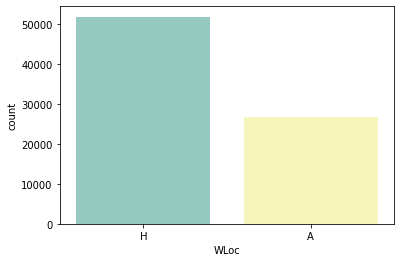

In [112]:
sns.countplot (x="WLoc",data =capstonem,palette="Set3")

In [113]:
capstonem['WLoc'].value_counts() 

H    51825
A    26759
Name: WLoc, dtype: int64

In [114]:
away = capstonem['WLoc'].value_counts()[1] # first value of the result above
home = capstonem['WLoc'].value_counts()[0] # second value of the result above
total = home+ away # total count of matches
perc_away=away/ total # converting to float to get a float result
perc_home=home/ total
print("Percent of away: {}".format(perc_away))
print("Percent of home: {}".format(perc_home))  

Percent of away: 0.34051460857171945
Percent of home: 0.6594853914282806


**Creating variables for the winning, losing away and home locations
where a=away,l=losing,h=home,w=win**

In [115]:
wcols=["Season",'WFGM',	'WFGA',	'WFGM3',	'WFGA3',	'WFTM',	'WFTA',	'WOR',	'WDR',	'WAst',	'WTO',	'WStl',	'WBlk',	'WPF',"WLoc","WTeamID"]
lcols=["Season",'LFGM',	'LFGA',	'LFGM3',	'LFGA3',	'LFTM',	'LFTA',	'LOR',	'LDR',	'LAst',	'LTO',	'LStl',	'LBlk',	'LPF',"LLoc","LTeamID"]
acols=["Season",'AFGM',	'AFGA',	'AFGM3',	'AFGA3',	'AFTM',	'AFTA',	'AOR',	'ADR',	'AAst',	'ATO',	'AStl',	'ABlk',	'APF',"ALoc","ATeamID"]
hcols=["Season",'HFGM',	'HFGA',	'HFGM3',	'HFGA3',	'HFTM',	'HFTA',	'HOR',	'HDR',	'HAst',	'HTO',	'HStl',	'HBlk',	'HPF',"HLoc","HTeamID"]

In [116]:
for i in range(0,len(acols)):
  capstonem[acols[i]]=[capstonem.loc[j,wcols[i]] if capstonem.loc[j,"WLoc"]=="A" 
                       else capstonem.loc[j,lcols[i]] for j in range (0,len(capstonem))]

In [117]:
for i in range(0,len(hcols)):
  capstonem[hcols[i]]=[capstonem.loc[j,wcols[i]] if capstonem.loc[j,"WLoc"]=="H" 
                       else capstonem.loc[j,lcols[i]] for j in range (0,len(capstonem))]

In [118]:
for i in range(0,len(acols)):
  capstonem[acols[i]]=[capstonem.loc[j,wcols[i]] if capstonem.loc[j,"LLoc"]=="A" 
                       else capstonem.loc[j,lcols[i]] for j in range (0,len(capstonem))]                            

In [119]:
for i in range(0,len(hcols)):
  capstonem[hcols[i]]=[capstonem.loc[j,wcols[i]] if capstonem.loc[j,"LLoc"]=="H" 
                       else capstonem.loc[j,lcols[i]] for j in range (0,len(capstonem))]

In [121]:
capstonem

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,LLoc,AFGM,AFGA,AFGM3,AFGA3,AFTM,AFTA,AOR,ADR,AAst,ATO,AStl,ABlk,APF,ALoc,ATeamID,HFGM,HFGA,HFGM3,HFGA3,HFTM,HFTA,HOR,HDR,HAst,HTO,HStl,HBlk,HPF,HLoc,HTeamID,AFGM3Rat,HFGM3Rat,AFGARat,HFGARat,AFTMRat,HFTMRat,AAstRat,HAStRat
0,2003,11,1458,81,1186,55,H,0,26,57,6,12,23,27,12,24,12,9,9,3,18,20,46,3,11,12,17,6,22,8,19,4,3,25,A,26,57,6,12,23,27,12,24,12,9,9,3,18,H,1458,20,46,3,11,12,17,6,22,8,19,4,3,25,A,1186,0.50,0.27,0.46,0.43,0.85,1.0,0.46,0.40
1,2003,12,1161,80,1236,62,H,0,23,55,2,8,32,39,13,18,14,17,11,1,25,19,41,4,15,20,28,9,21,11,30,10,4,28,A,23,55,2,8,32,39,13,18,14,17,11,1,25,H,1161,19,41,4,15,20,28,9,21,11,30,10,4,28,A,1236,0.25,0.27,0.42,0.46,0.82,1.0,0.61,0.58
2,2003,12,1458,84,1296,56,H,0,32,67,5,17,15,19,14,22,11,6,12,0,13,23,52,3,14,7,12,9,23,10,18,1,3,18,A,32,67,5,17,15,19,14,22,11,6,12,0,13,H,1458,23,52,3,14,7,12,9,23,10,18,1,3,18,A,1296,0.29,0.21,0.48,0.44,0.79,1.0,0.34,0.43
3,2003,13,1166,106,1426,50,H,0,41,69,15,25,9,13,15,29,21,11,10,6,16,17,52,4,11,12,17,8,15,8,17,7,3,15,A,41,69,15,25,9,13,15,29,21,11,10,6,16,H,1166,17,52,4,11,12,17,8,15,8,17,7,3,15,A,1426,0.60,0.36,0.59,0.33,0.69,1.0,0.51,0.47
4,2003,13,1323,76,1125,48,H,0,25,56,10,23,16,23,8,35,18,13,14,19,13,18,64,8,24,4,8,14,26,12,17,10,0,17,A,25,56,10,23,16,23,8,35,18,13,14,19,13,H,1323,18,64,8,24,4,8,14,26,12,17,10,0,17,A,1125,0.43,0.33,0.45,0.28,0.70,1.0,0.72,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78579,2019,130,1272,79,1416,55,H,0,26,57,8,27,19,29,14,27,16,13,9,2,19,19,53,6,20,11,19,8,22,7,16,6,6,21,A,26,57,8,27,19,29,14,27,16,13,9,2,19,H,1272,19,53,6,20,11,19,8,22,7,16,6,6,21,A,1416,0.30,0.30,0.46,0.36,0.66,1.0,0.62,0.37
78580,2019,131,1222,61,1272,58,A,0,21,57,5,19,14,27,16,32,8,14,4,9,22,16,68,4,23,22,26,21,26,4,9,5,5,21,H,16,68,4,23,22,26,21,26,4,9,5,5,21,H,1272,21,57,5,19,14,27,16,32,8,14,4,9,22,A,1222,0.17,0.26,0.24,0.37,0.85,1.0,0.25,0.38
78581,2019,131,1436,66,1420,49,H,0,21,51,7,22,17,23,11,27,7,11,5,5,16,15,44,8,26,11,14,4,23,9,13,6,4,19,A,21,51,7,22,17,23,11,27,7,11,5,5,16,H,1436,15,44,8,26,11,14,4,23,9,13,6,4,19,A,1420,0.32,0.31,0.41,0.34,0.74,1.0,0.33,0.60
78582,2019,131,1463,83,1343,77,H,0,31,61,5,16,16,16,6,26,16,8,8,2,18,28,62,6,24,15,20,9,24,9,10,4,1,17,A,31,61,5,16,16,16,6,26,16,8,8,2,18,H,1463,28,62,6,24,15,20,9,24,9,10,4,1,17,A,1343,0.31,0.25,0.51,0.45,1.00,1.0,0.52,0.32


 The dataframe is rearranged by splitting the losing team stats from the winning team stats. The winning team statistics is dropped from the major dataframe capstonem The losing team statistics will then be merged to the winning team in a row wise manner.

In [122]:
capstoneloss=capstonem.drop(columns=["LLoc","NumOT",	"WTeamID"	,"WScore",	"WFGM",	"WFGA",	"WFGM3",	"WFGA3",	"WFTM",	"WFTA",	"WOR",	"WDR",	"WAst",	"WTO",	"WStl",	"WBlk",	"WPF","AFGM",	"AFGA","AFGM3",	"AFGA3",	"AFTM",	"AFTA",	"AOR",	"ADR"	,"AAst"	,"ATO",	"AStl",	"ABlk",	"APF",	"ALoc",	"ATeamID",	"HFGM",	"HFGA",	"HFGM3",	"HFGA3",	"HFTM",	"HFTA",	"HOR",	"HDR",	"HAst",	"HTO",	"HStl",	"HBlk",	"HPF",	"HLoc",	"HTeamID",	"AFGM3Rat",	"HFGM3Rat",	"AFGARat",	"HFGARat",	"AFTMRat",	"HFTMRat",	"AAstRat",	"HAStRat"])

capstoneloss['LResults'] = ["L"]*len(capstoneloss) # Creating a location for the losing team, since data only comes with location of winning team
capstoneloss.head(5)

,Season,DayNum,LTeamID,LScore,WLoc,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,LResults
0,2003,11,1186,55,H,20,46,3,11,12,17,6,22,8,19,4,3,25,L
1,2003,12,1236,62,H,19,41,4,15,20,28,9,21,11,30,10,4,28,L
2,2003,12,1296,56,H,23,52,3,14,7,12,9,23,10,18,1,3,18,L
3,2003,13,1426,50,H,17,52,4,11,12,17,8,15,8,17,7,3,15,L
4,2003,13,1125,48,H,18,64,8,24,4,8,14,26,12,17,10,0,17,L


In [123]:
capstoneloss['WLoc'].value_counts() 

H    51825
A    26759
Name: WLoc, dtype: int64

 The dataframe is rearranged by splitting the winning team stats from the losing team stats. The losing team statistics is dropped from the major dataframe capstonem The winning team statistics will then be merged to the losing team in a row wise manner.

In [124]:
capstonewin=capstonem.drop(columns=["LLoc","NumOT",	"LTeamID"	,"LScore",	"LFGM",	"LFGA",	"LFGM3",	"LFGA3",	"LFTM",	"LFTA",	"LOR",	"LDR",	"LAst",	"LTO",	"LStl",	"LBlk",	"LPF","AFGM",	"AFGA","AFGM3",	"AFGA3",	"AFTM",	"AFTA",	"AOR",	"ADR"	,"AAst"	,"ATO",	"AStl",	"ABlk",	"APF",	"ALoc",	"ATeamID",	"HFGM",	"HFGA",	"HFGM3",	"HFGA3",	"HFTM",	"HFTA",	"HOR",	"HDR",	"HAst",	"HTO",	"HStl",	"HBlk",	"HPF",	"HLoc",	"HTeamID",	"AFGM3Rat",	"HFGM3Rat",	"AFGARat",	"HFGARat",	"AFTMRat",	"HFTMRat",	"AAstRat",	"HAStRat"])

capstonewin['WResults'] = ["W"]*len(capstonewin) # Creating a winning team column W
capstonewin.head(5)

,Season,DayNum,WTeamID,WScore,WLoc,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,WResults
0,2003,11,1458,81,H,26,57,6,12,23,27,12,24,12,9,9,3,18,W
1,2003,12,1161,80,H,23,55,2,8,32,39,13,18,14,17,11,1,25,W
2,2003,12,1458,84,H,32,67,5,17,15,19,14,22,11,6,12,0,13,W
3,2003,13,1166,106,H,41,69,15,25,9,13,15,29,21,11,10,6,16,W
4,2003,13,1323,76,H,25,56,10,23,16,23,8,35,18,13,14,19,13,W


The winning team dataframe and losing team dataframe are now renamed so that the names of both columns are identical and can thus be easily merged together

In [125]:
capstonewin=capstonewin.rename(columns={"WTeamID":"TeamID",	"WScore":"Score",	"NumOT":"OT", "WFGM":"FGM",	"WFGA":	"FGA",	"WFGA3":"FGA3",	"WFTM":"FTM",	"WFTA":"FTA",	"WOR":"OR",	"WDR":"DR",	"WAst":"Ast"	,"WTO":"TO"	,"WStl":"Stl"	,"WBlk":"Blk", "WPF":"PF","WFGM3":"FGM3","WResults":"Results"})
capstoneloss=capstoneloss.rename(columns={"LTeamID":"TeamID",	"LScore":"Score",	"NumOT":"OT", "LFGM":"FGM",	"LFGM3":"FGM3","LFGA":	"FGA",	"LFGA3":"FGA3",	"LFTM":"FTM",	"LFTA":"FTA",	"LOR":"OR",	"LDR":"DR",	"LAst":"Ast"	,"LTO":"TO"	,"LStl":"Stl"	,"LBlk":"Blk", "LPF":"PF","LResults":"Results","Loc":"WLoc"})
res4=pd.concat([capstonewin, capstoneloss]) # Merging of the win and loss dataframes in a row-wise manner

res4.reset_index(inplace=True,drop=True)
res4 # New dataframe is now called res4

,Season,DayNum,TeamID,Score,WLoc,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Results
0,2003,11,1458,81,H,26,57,6,12,23,27,12,24,12,9,9,3,18,W
1,2003,12,1161,80,H,23,55,2,8,32,39,13,18,14,17,11,1,25,W
2,2003,12,1458,84,H,32,67,5,17,15,19,14,22,11,6,12,0,13,W
3,2003,13,1166,106,H,41,69,15,25,9,13,15,29,21,11,10,6,16,W
4,2003,13,1323,76,H,25,56,10,23,16,23,8,35,18,13,14,19,13,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157163,2019,130,1416,55,H,19,53,6,20,11,19,8,22,7,16,6,6,21,L
157164,2019,131,1272,58,A,16,68,4,23,22,26,21,26,4,9,5,5,21,L
157165,2019,131,1420,49,H,15,44,8,26,11,14,4,23,9,13,6,4,19,L
157166,2019,131,1343,77,H,28,62,6,24,15,20,9,24,9,10,4,1,17,L


In [126]:
res4['WLoc'].value_counts() 

H    103650
A     53518
Name: WLoc, dtype: int64

Need to create a unique identifier for the dataframe after merging the columns. The unique identifier is a merger of the season being played, and the days of the season. 


In [127]:
res4["DayNum"]=res4["DayNum"].astype(str) #Converting Day Num to string, so that it can be concatenated
type(res4.loc[5,"DayNum"])
res4['DayNum'] = ['0' + val if len(val) < 3 else val for val in res4['DayNum']] # Assigning a zero for daynum, so that it counts in an orderly fashion
res4['identifier'] = [str(res4.loc[i,'Season']) + '_' + str(res4.loc[i,'DayNum']) for i in range(0,len(res4))] # concatenating season and day number
res4

,Season,DayNum,TeamID,Score,WLoc,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Results,identifier
0,2003,011,1458,81,H,26,57,6,12,23,27,12,24,12,9,9,3,18,W,2003_011
1,2003,012,1161,80,H,23,55,2,8,32,39,13,18,14,17,11,1,25,W,2003_012
2,2003,012,1458,84,H,32,67,5,17,15,19,14,22,11,6,12,0,13,W,2003_012
3,2003,013,1166,106,H,41,69,15,25,9,13,15,29,21,11,10,6,16,W,2003_013
4,2003,013,1323,76,H,25,56,10,23,16,23,8,35,18,13,14,19,13,W,2003_013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157163,2019,130,1416,55,H,19,53,6,20,11,19,8,22,7,16,6,6,21,L,2019_130
157164,2019,131,1272,58,A,16,68,4,23,22,26,21,26,4,9,5,5,21,L,2019_131
157165,2019,131,1420,49,H,15,44,8,26,11,14,4,23,9,13,6,4,19,L,2019_131
157166,2019,131,1343,77,H,28,62,6,24,15,20,9,24,9,10,4,1,17,L,2019_131


Original Dataframe only has winning location, created a data frame to assign location of winning team and losing teeam

In [129]:
my_dict = {('H','W'):'H',('H','L'):'A',('A','W'):'A',('A','L'):'H'} 
res4['Loc'] = [my_dict[(res4['WLoc'][i],res4['Results'][i])] for i in range(0,len(res4))]  # creating a dictionary that creates a location for winning, losing and away and home team. Rather than only winning location
res4

,Season,DayNum,TeamID,Score,WLoc,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Results,identifier,Loc
0,2003,011,1458,81,H,26,57,6,12,23,27,12,24,12,9,9,3,18,W,2003_011,H
1,2003,012,1161,80,H,23,55,2,8,32,39,13,18,14,17,11,1,25,W,2003_012,H
2,2003,012,1458,84,H,32,67,5,17,15,19,14,22,11,6,12,0,13,W,2003_012,H
3,2003,013,1166,106,H,41,69,15,25,9,13,15,29,21,11,10,6,16,W,2003_013,H
4,2003,013,1323,76,H,25,56,10,23,16,23,8,35,18,13,14,19,13,W,2003_013,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157163,2019,130,1416,55,H,19,53,6,20,11,19,8,22,7,16,6,6,21,L,2019_130,A
157164,2019,131,1272,58,A,16,68,4,23,22,26,21,26,4,9,5,5,21,L,2019_131,H
157165,2019,131,1420,49,H,15,44,8,26,11,14,4,23,9,13,6,4,19,L,2019_131,A
157166,2019,131,1343,77,H,28,62,6,24,15,20,9,24,9,10,4,1,17,L,2019_131,A


In [131]:
res4=res4.drop(columns=["WLoc"])	# drop winning location since location column has been created

In [132]:
res4

,Season,DayNum,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Results,identifier,Loc
0,2003,011,1458,81,26,57,6,12,23,27,12,24,12,9,9,3,18,W,2003_011,H
1,2003,012,1161,80,23,55,2,8,32,39,13,18,14,17,11,1,25,W,2003_012,H
2,2003,012,1458,84,32,67,5,17,15,19,14,22,11,6,12,0,13,W,2003_012,H
3,2003,013,1166,106,41,69,15,25,9,13,15,29,21,11,10,6,16,W,2003_013,H
4,2003,013,1323,76,25,56,10,23,16,23,8,35,18,13,14,19,13,W,2003_013,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157163,2019,130,1416,55,19,53,6,20,11,19,8,22,7,16,6,6,21,L,2019_130,A
157164,2019,131,1272,58,16,68,4,23,22,26,21,26,4,9,5,5,21,L,2019_131,H
157165,2019,131,1420,49,15,44,8,26,11,14,4,23,9,13,6,4,19,L,2019_131,A
157166,2019,131,1343,77,28,62,6,24,15,20,9,24,9,10,4,1,17,L,2019_131,A


Preparing the data for machine modeling. The training data is from 2003-2018, while the test data is the 2019 season

Converting Win and Losses to 0 and 1 for  logistic regression calculations. Where Loss is 0 and win is 1

In [133]:
res4['Results'] = [1 if val == 'W' else 0 for val in res4['Results']] # converting 
res4["Loc"] = [1 if val == 'H' else 0 for val in res4['Loc']]


In [134]:
res4_2003_2018 = res4[res4["Season"] < 2019] # Collecting data for 2003 to 2018 season to be used for training data
res4_2019 = res4[res4["Season"] > 2018] # Collecting data for 2019 season to be sued for testing data

In [135]:
res4_2019

,Season,DayNum,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Results,identifier,Loc
73730,2019,01,1104,82,27,55,9,24,19,28,16,29,17,20,3,6,24,1,2019_01,1
73731,2019,01,1113,102,33,78,10,26,26,44,20,38,11,17,3,2,26,1,2019_01,1
73732,2019,01,1119,73,22,51,9,30,20,29,6,22,14,6,5,1,22,1,2019_01,1
73733,2019,01,1120,101,38,74,18,38,7,14,19,23,24,13,9,8,21,1,2019_01,1
73734,2019,01,1123,86,32,65,7,19,15,20,16,26,14,9,7,5,18,1,2019_01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157163,2019,130,1416,55,19,53,6,20,11,19,8,22,7,16,6,6,21,0,2019_130,0
157164,2019,131,1272,58,16,68,4,23,22,26,21,26,4,9,5,5,21,0,2019_131,1
157165,2019,131,1420,49,15,44,8,26,11,14,4,23,9,13,6,4,19,0,2019_131,0
157166,2019,131,1343,77,28,62,6,24,15,20,9,24,9,10,4,1,17,0,2019_131,0


In [136]:
res4_2003_2018

,Season,DayNum,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Results,identifier,Loc
0,2003,011,1458,81,26,57,6,12,23,27,12,24,12,9,9,3,18,1,2003_011,1
1,2003,012,1161,80,23,55,2,8,32,39,13,18,14,17,11,1,25,1,2003_012,1
2,2003,012,1458,84,32,67,5,17,15,19,14,22,11,6,12,0,13,1,2003_012,1
3,2003,013,1166,106,41,69,15,25,9,13,15,29,21,11,10,6,16,1,2003_013,1
4,2003,013,1323,76,25,56,10,23,16,23,8,35,18,13,14,19,13,1,2003_013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152309,2018,127,1106,76,30,74,9,25,7,22,16,19,16,12,3,5,28,0,2018_127,0
152310,2018,127,1216,60,21,52,10,29,8,23,8,24,11,15,6,1,25,0,2018_127,0
152311,2018,127,1392,51,19,57,3,19,10,14,12,27,4,14,3,3,29,0,2018_127,0
152312,2018,128,1159,54,17,52,6,17,14,18,9,24,7,10,4,3,13,0,2018_128,0


In [137]:
res4_2003_2018["Results"].unique() # Win and loss data converted to 0 and 1

array([1, 0])

Creating a dictionary to sort teams in seasons so that a rolling average can be made on the independent variable.  The teams were sorted in terms of the unique identifier created.
The dependent variable is dropped from the rolling average calculation.

In [138]:
my_dict={}
for team in res4_2003_2018["TeamID"].unique():
   data = res4_2003_2018[res4_2003_2018['TeamID'] == team ]
   data.sort_values("identifier",inplace=True) # Sort the teams per season in terms of the identifier created.
   my_dict[team] = [data.drop(columns=["Results","Loc"])] # Dropping the dependent variable
   my_dict[team].append(data[["Results","Loc"]])

   my_dict[team].append(my_dict[team][0].rolling(2).mean().shift())

   final_table = pd.concat([my_dict[team][2],my_dict[team][1]],axis=1)
   my_dict[team].append(final_table)

In [139]:

full_table = pd.concat([my_dict[team][3] for team in res4_2003_2018['TeamID'].unique()])
full_table

,Season,DayNum,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,identifier,Results,Loc
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
123,2003.0,11.5,1458.0,82.5,29.0,62.0,5.5,14.5,19.0,23.0,13.0,23.0,11.5,7.5,10.5,1.5,15.5,2003011.5,1,1
360,2003.0,15.5,1458.0,83.5,28.5,61.0,6.0,15.0,20.5,25.5,13.5,26.5,13.0,9.5,7.0,2.5,14.5,2003015.5,1,0
79088,2003.0,22.5,1458.0,76.0,24.5,56.0,5.5,14.5,21.5,27.0,13.0,27.5,12.0,10.0,6.0,5.0,12.5,2003022.5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151662,2018.0,101.5,1101.0,72.5,28.0,61.0,6.0,22.5,10.5,15.0,16.0,23.0,11.5,15.0,7.5,3.5,21.0,2018101.5,0,0
151808,2018.0,106.5,1101.0,67.0,25.5,60.5,6.5,19.5,9.5,14.0,16.0,23.5,12.5,16.0,7.0,3.5,19.5,2018106.5,0,1
151920,2018.0,112.0,1101.0,60.5,21.5,56.5,4.0,19.5,13.5,20.5,12.0,22.0,8.0,15.5,7.5,1.5,16.5,2018112.0,0,1
152137,2018.0,115.5,1101.0,69.5,27.5,61.0,3.5,19.0,11.0,18.5,11.0,22.0,9.5,13.0,9.5,3.0,20.0,2018115.5,0,0


In [140]:
full_table=full_table.dropna() # Dropping the first two rows of averaged data

In [141]:

Team_total=full_table # Assigning full_table to team_total

**Feature Selection**

1.   Split the data into X &y
2.   Feature Selection: Run Chi square test and RFE
3.   Rank features
4.   Compare before and after feature selection for chi sq and RFE
5.   Plot ROC and AUC curve


**1.Split the data into X & y**

Before doing feature selection, we will need to split the data. The reason for this is that features are selected based on the information on the training set not on the whole data set. The test set is kept separate so as to evaluate the performance of the feature selection

In [142]:
#Define y:  y=Results Set Win =1 and Loss = 0

#Team_total['Results'] = [1 if val == 'W' else 0 for val in Team_total['L']]
y=Team_total.Results #Dependent variable
X =Team_total.drop(["Results"], axis=1) # # Creating training data 
                 

**Reference for Feature Selection**
https://scikit-learn.org/stable/modules/feature_selection.html

**2a.Separating the test  data set aside and not using it in feature selection process for the matches played at HOME**

**Evaluating Home Game Matches Model Using all Features**

**Home Game Features**

In [143]:
Test_home= res4_2019[res4_2019["Loc"]==1] #Sorting data by Home matches
X_test_home=Test_home.drop(columns=["Season","DayNum","TeamID","identifier","Results","Score","Loc"])

X_test_home

,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
73730,27,55,9,24,19,28,16,29,17,20,3,6,24
73731,33,78,10,26,26,44,20,38,11,17,3,2,26
73732,22,51,9,30,20,29,6,22,14,6,5,1,22
73733,38,74,18,38,7,14,19,23,24,13,9,8,21
73734,32,65,7,19,15,20,16,26,14,9,7,5,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157148,15,51,5,21,8,16,14,18,8,13,6,4,16
157151,15,47,4,15,15,24,9,21,10,11,11,6,18
157152,30,63,12,23,4,17,15,14,15,10,4,2,16
157162,20,62,4,22,11,16,11,32,12,10,2,4,23


In [144]:
y_test_home =Test_home["Results"].values # win and loss  results
y_test_home

array([1, 1, 1, ..., 0, 0, 0])

In [146]:
X_train_home=Team_total[Team_total["Loc"]==1]
X_train_home=X_train_home.drop(columns=["Season","DayNum","TeamID","identifier","Score","Results","Loc"])

X_train_home

,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
123,29.0,62.0,5.5,14.5,19.0,23.0,13.0,23.0,11.5,7.5,10.5,1.5,15.5
79088,24.5,56.0,5.5,14.5,21.5,27.0,13.0,27.5,12.0,10.0,6.0,5.0,12.5
638,26.0,56.5,6.5,20.0,16.0,23.0,11.0,21.0,12.5,10.0,8.0,3.5,15.0
712,29.0,59.0,6.0,18.5,21.5,32.0,13.0,24.5,16.0,12.5,6.0,2.5,20.0
1025,26.5,57.5,5.0,19.5,11.5,15.0,14.0,18.5,14.5,10.5,10.5,3.5,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72190,23.0,53.5,8.0,22.5,19.0,25.0,9.5,23.0,15.5,15.0,8.5,2.5,21.0
151123,27.0,50.5,7.5,18.5,14.0,21.0,7.0,27.5,19.0,17.5,5.0,4.0,24.5
72649,26.5,56.0,5.0,19.5,13.0,18.5,12.5,22.0,11.5,16.0,6.5,2.5,20.5
151808,25.5,60.5,6.5,19.5,9.5,14.0,16.0,23.5,12.5,16.0,7.0,3.5,19.5


In [147]:
y_train_home= Team_total[Team_total["Loc"]==1] #sorting by home matches
y_train_home=y_train_home["Results"] # Win and loss result for home matches

**Evaluating the model using all features**



In [148]:
# construct the LogisticRegression model
clf = LogisticRegression()

# Fit the model on the training data.
clf.fit(X_train_home, y_train_home) 

# Print the accuracy from the testing data.

y_predict_test = clf.predict(X_test_home)
print("\n")
print("[Test] Accuracy score (y_predict_test, ytesthome):",accuracy_score(y_predict_test, y_test_home))





[Test] Accuracy score (y_predict_test, ytesthome): 0.6985990935311084


In [149]:
# use sklearn.metrics.classification_report for a more comprehensive
# performance analysis

from sklearn.metrics import classification_report
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

print(X_test_home.shape)


print("\n")
print(confusion_matrix(y_test_home, y_predict_test))
print("\n")

print("[Test Classification Report]")
print(classification_report(y_test_home, y_predict_test))
# Print the accuracy from the testing data.
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest_home):",accuracy_score(y_predict_test, y_test_home))


(4854, 13)


[[ 258 1455]
 [   8 3133]]


[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.15      0.26      1713
           1       0.68      1.00      0.81      3141

    accuracy                           0.70      4854
   macro avg       0.83      0.57      0.54      4854
weighted avg       0.78      0.70      0.62      4854



[Test] Accuracy score (y_predict_test, ytest_home): 0.6985990935311084


**Features Recommended by RFE**

In [150]:

model_logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
sel_rfe_logistic = RFE(estimator=model_logistic, n_features_to_select=5, step=1) # Selecting top five features from RFE 
X_train_home_rfe_logistic = sel_rfe_logistic.fit_transform(X_train_home,y_train_home)

In [151]:
# All the features with the value 1 are the most important features 
selected_rfe_features=pd.DataFrame({'Feature':list(X_train_home.columns),'Ranking':sel_rfe_logistic.ranking_})
selected_rfe_features.sort_values(by="Ranking")

,Feature,Ranking
0,FGM,1
1,FGA,1
6,OR,1
9,TO,1
11,Blk,1
10,Stl,2
7,DR,3
4,FTM,4
5,FTA,5
3,FGA3,6


In [152]:
 #we use the result from the feature selection based on the RFE test

In [153]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg =LogisticRegression()
rfe=RFE(logreg,5) # Picking the top 5 features for calibration
rfe=rfe.fit(X_train_home,y_train_home)
print(X_train_home_rfe_logistic.shape)
print(X_test_home.shape)


(73389, 5)
(4854, 13)


In [154]:
print(X_test_home.shape)
y_predict_test = rfe.predict(X_test_home)
print("[Confusion Matrix for Test Data using RFE]")
print(confusion_matrix(y_test_home,y_predict_test))

print("\n")
print("[Test Classification Report]")
print(classification_report(y_test_home, y_predict_test))


y_predict_training = rfe.predict(X_train_home)

# Print the accuracy from the testing data.
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest_home):",accuracy_score(y_predict_test, y_test_home))


(4854, 13)
[Confusion Matrix for Test Data using RFE]
[[ 276 1437]
 [  41 3100]]


[Test Classification Report]
              precision    recall  f1-score   support

           0       0.87      0.16      0.27      1713
           1       0.68      0.99      0.81      3141

    accuracy                           0.70      4854
   macro avg       0.78      0.57      0.54      4854
weighted avg       0.75      0.70      0.62      4854



[Test] Accuracy score (y_predict_test, ytest_home): 0.6955088586732592


In [155]:

# Compute predicted probabilities: y_pred_prob

# Compute predicted probabilities: y_pred_prob
logreg.fit(X_train_home, y_train_home)
y_pred_prob = logreg.predict_proba(X_test_home)[:,1]
logreg.fit(X, y)
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_predict_test, y_pred_prob)))
#
# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))


AUC: 0.9484219828692092
AUC scores computed using 5-fold cross-validation: [0.47300468 0.53468432 0.60063523 0.49177316 0.52491914]


Text(0.5, 1.0, 'ROC Curve')

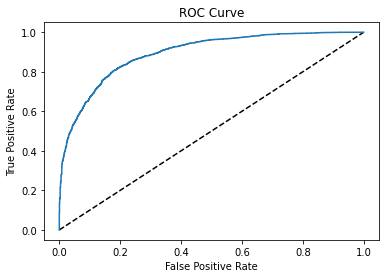

In [156]:
# Import necessary modules
#from sklearn.metrics import roc_curve
logreg.fit(X_train_home, y_train_home)
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test_home)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_home, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

***Evaluating Away Game Matches Model Using all Features***



In [157]:
X_test_away1= res4_2019[res4_2019["Loc"]!=1]
X_test_away=X_test_away1.drop(columns=["Season","DayNum","TeamID","identifier","Results","Score","Loc"])
X_test_away

,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
73736,29,59,6,16,13,22,13,25,10,11,7,1,21
73739,29,61,2,7,15,20,13,25,12,14,4,7,21
73740,26,55,11,21,17,20,9,21,10,10,5,2,22
73743,27,58,7,23,25,34,8,34,14,15,7,1,17
73748,21,45,8,22,12,18,7,28,13,18,2,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157161,27,69,6,23,8,13,10,23,17,10,7,1,18
157163,19,53,6,20,11,19,8,22,7,16,6,6,21
157165,15,44,8,26,11,14,4,23,9,13,6,4,19
157166,28,62,6,24,15,20,9,24,9,10,4,1,17


In [158]:
y_test_away =X_test_away1["Results"].values


In [159]:
X_train_away=Team_total[Team_total["Loc"]!=1]
X_train_away=X_train_away.drop(columns=["Season","DayNum","TeamID","identifier","Score","Results","Loc"])

X_train_away

,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
360,28.5,61.0,6.0,15.0,20.5,25.5,13.5,26.5,13.0,9.5,7.0,2.5,14.5
79341,32.0,62.5,4.0,16.5,20.0,27.5,17.5,25.5,16.0,11.5,11.0,4.5,14.0
1361,28.5,57.0,8.0,17.0,13.0,19.0,12.0,24.0,17.5,10.5,10.0,4.5,12.5
80162,25.0,44.0,7.5,16.5,19.0,23.5,6.5,24.5,15.5,13.0,7.0,4.5,13.5
80294,25.0,48.5,4.5,11.5,14.5,20.5,7.5,23.0,13.5,15.5,8.5,4.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150496,23.5,49.5,8.0,19.5,18.0,24.5,8.5,26.0,17.0,16.5,5.0,6.5,24.5
151006,22.0,50.0,7.0,21.0,19.0,25.5,6.0,24.5,17.0,17.5,8.0,2.5,22.5
151662,28.0,61.0,6.0,22.5,10.5,15.0,16.0,23.0,11.5,15.0,7.5,3.5,21.0
152137,27.5,61.0,3.5,19.0,11.0,18.5,11.0,22.0,9.5,13.0,9.5,3.0,20.0


In [160]:
y_train_away= Team_total[Team_total["Loc"]!=1]
y_train_away=y_train_away["Results"]

In [161]:
model_logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)
model_logistic.fit(X_train_away, y_train_away)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [162]:
# use sklearn.metrics.classification_report for a more comprehensive
# performance analysis
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
print(X_test_away.shape)
predict = model_logistic.predict(X_test_away)
#print(predict.shape)
print(confusion_matrix(y_test_away, predict))
print(classification_report(y_test_away, predict))

# Accuracy on Test

print("[Test] Accuracy score (y_predict_test, ytest_away):",accuracy_score(predict, y_test_away))

(4854, 13)
[[3136    5]
 [1462  251]]
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      3141
           1       0.98      0.15      0.25      1713

    accuracy                           0.70      4854
   macro avg       0.83      0.57      0.53      4854
weighted avg       0.79      0.70      0.61      4854

[Test] Accuracy score (y_predict_test, ytest_away): 0.6977750309023486



***Features Recommended by RFE for away matches***

In [163]:

model_logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
sel_rfe_logistic = RFE(estimator=model_logistic, n_features_to_select=5, step=1)
X_train_away_rfe_logistic = sel_rfe_logistic.fit_transform(X_train_away,y_train_away)

In [164]:
from sklearn.feature_selection import RFE
model_logistic = sel_rfe_logistic.fit_transform(X_train_away, y_train_away)
print(X_test_away.shape)
#print(X_train_away_rfe_logistic.shape)

(4854, 13)


In [165]:
# All the features with the value 1 are the most important features
selected_rfe_features=pd.DataFrame({'Feature':list(X_train_away.columns),'Ranking':sel_rfe_logistic.ranking_})
selected_rfe_features.sort_values(by="Ranking")

,Feature,Ranking
0,FGM,1
1,FGA,1
6,OR,1
9,TO,1
10,Stl,1
7,DR,2
11,Blk,3
4,FTM,4
5,FTA,5
3,FGA3,6


In [166]:
y_predict_test = rfe.predict(X_test_away)
print("[Confusion Matrix for Test Data using RFE]")
print(confusion_matrix(y_test_away,y_predict_test))

print("\n")
print("[Test Classification Report]")
print(classification_report(y_test_away, y_predict_test))

y_predict_training = rfe.predict(X_train_away)
print("\n")

# Print the accuracy from the testing data.

print("[Test] Accuracy score (y_predict_test, ytest_away):",accuracy_score(y_predict_test, y_test_away))


[Confusion Matrix for Test Data using RFE]
[[ 876 2265]
 [  27 1686]]


[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.28      0.43      3141
           1       0.43      0.98      0.60      1713

    accuracy                           0.53      4854
   macro avg       0.70      0.63      0.51      4854
weighted avg       0.78      0.53      0.49      4854



[Test] Accuracy score (y_predict_test, ytest_away): 0.5278121137206427


In [171]:

# Compute predicted probabilities: y_pred_prob

# Compute predicted probabilities: y_pred_prob
logreg.fit(X_test_away, y_test_away)
y_pred_prob = logreg.predict_proba(X_test_away)[:,1]
logreg.fit(X, y)
# Compute and print AUC score
#print("AUC: {}".format(roc_auc_score(y_predict_test, y_pred_prob)))
print("AUC: {}".format(roc_auc_score(predict, y_pred_prob)))
# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.9775666730100043
AUC scores computed using 5-fold cross-validation: [0.47300468 0.53468432 0.60063523 0.49177316 0.52491914]
AUC scores computed using 5-fold cross-validation: [0.47300468 0.53468432 0.60063523 0.49177316 0.52491914]


Text(0.5, 1.0, 'ROC Curve')

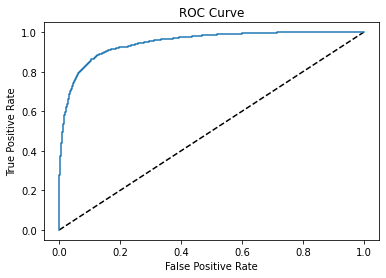

In [172]:
# Import necessary modules
from sklearn.metrics import roc_curve
logreg.fit(X_test_away, y_test_away)
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test_away)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_away, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

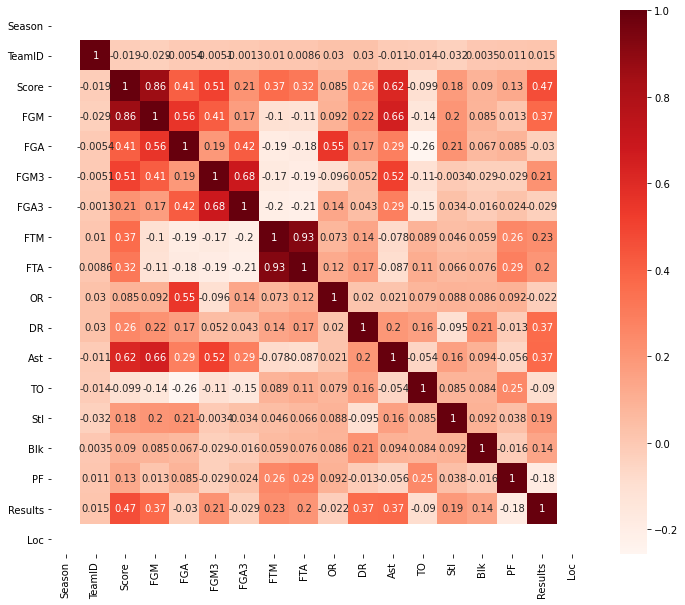

In [173]:
#Team_total=pd.concat([final_df2,reswloc],sort=False, axis=1)

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = Test_home.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


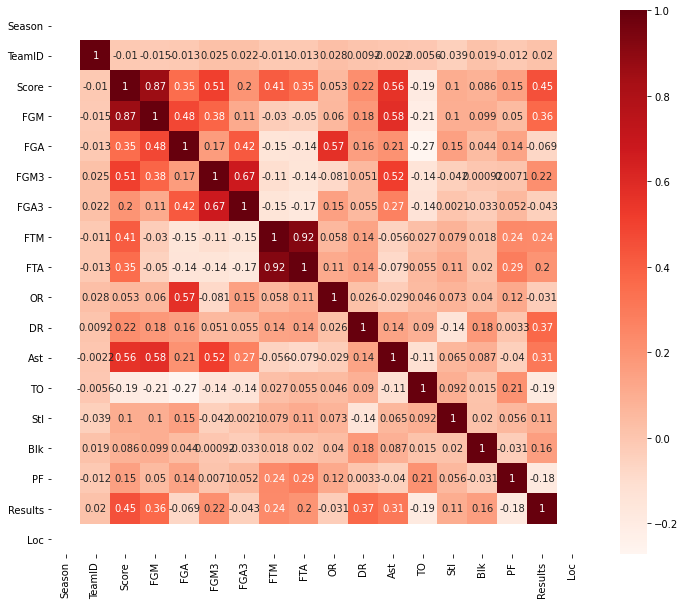

In [174]:
#Team_total=pd.concat([final_df2,reswloc],sort=False, axis=1)

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_test_away1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()